## Configure Pyspark

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
import findspark
findspark.init()

In [ ]:
!pip install sparknlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.4/489.4 kB 12.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import json

import sparknlp
import pyspark.sql.functions as F

from sparknlp.annotator import *
from sparknlp.base import *
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from sparknlp.pretrained import PretrainedPipeline
from pyspark.sql.types import StringType, IntegerType

In [ ]:
import pandas as pd
pd.set_option('display.max_columns',100, 'display.max_colwidth',1000, 'display.max_rows',1000, 
              'display.float_format', lambda x: '%.2f' % x)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob

## Read in data

In [ ]:
from pyspark.sql.functions import *
spark = sparknlp.start()

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filePath = "drive/MyDrive/Colab Notebooks/comments.csv.xls"
comments_df = spark.read.format("csv").option("header","true").load(filePath)

In [ ]:
def remove_stopwords(x):    
    sw = stopwords.words("english")
    string = ''
    if x is not None:
      for x in x.split(' '):
          if x.lower() not in sw:
              string += x + ' '
          else:
              pass
    else:
      pass
    return string

nosw = udf(remove_stopwords)
spark.udf.register("nosw", nosw)
comments_df = comments_df.withColumn('text_nosw',nosw('comment_text'))

In [ ]:
sentiment = udf(lambda x: TextBlob(x).sentiment[0] if x is not None else None)
spark.udf.register("sentiment", sentiment)
comments_df = comments_df.withColumn('sentiment',sentiment('comment_text').cast('double'))

In [ ]:
comments_df.select('sentiment').show()

+--------------------+
|           sentiment|
+--------------------+
|                 0.3|
|                 0.1|
|                 0.0|
|                 0.0|
|                 0.0|
| 0.29166666666666663|
|0.005555555555555554|
|                 0.8|
|                 0.0|
|                 0.5|
|                 0.0|
|-0.09062499999999996|
|  0.6000000000000001|
|                 0.5|
|                 0.0|
|                 0.5|
|                 1.0|
|                 0.5|
|                 0.0|
|                0.25|
+--------------------+
only showing top 20 rows



In [ ]:
# print average sentiment
comments_df.select(mean('sentiment')).collect()

[Row(avg(sentiment)=0.18557251609915978)]

In [ ]:
!pip install pyspark_dist_explore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Create some plots
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from pyspark.sql import Row

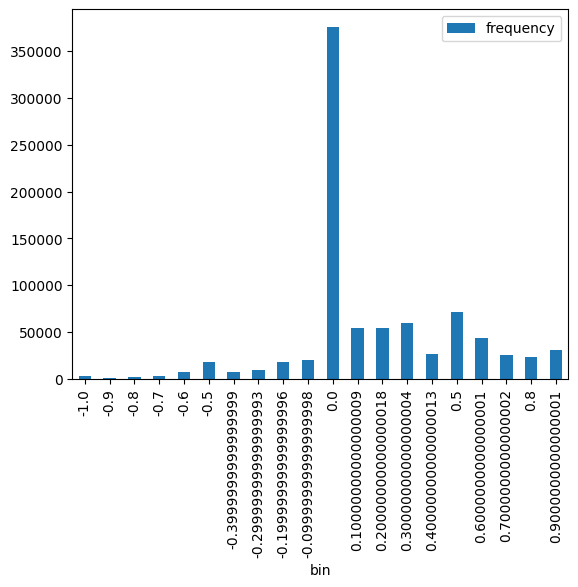

In [ ]:
# plot sentiment in a histogram
# Using the RDD 
hist = comments_df.select('sentiment').rdd.flatMap(lambda x: x).histogram(20)
# Load the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(list(zip(*hist)), columns=['bin', 'frequency']).set_index('bin').plot(kind='bar'); 

In [ ]:
## could i also just load this into a pandas dataframe and plot as regular?